# Machine Learning Foundation

## Course 5, Part a: Gradient Descent DEMO

## Overview
In this notebook, we will solve a simple linear regression problem by gradient descent.  
We will see the effect of the learning rate on the trajectory in parameter space.
We will show how Stochastic Gradient Descent (SGD) differs from the standard version, and the effect of "shuffling" your data during SGD.

In [1]:
# Preliminaries - packages to load
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Generate Data from a known distribution
Below we will generate data a known distribution.  
Specifically, the true model is:

$Y = b + \theta_1 X_1 + \theta_2 X_2 + \epsilon$

$X_1$ and $X_2$ have a uniform distribution on the interval $[0,10]$, while `const` is a vector of ones (representing the intercept term).

We set actual values for $b$ ,$\theta_1$, and $\theta_2$

Here $b=1.5$, $\theta_1=2$, and $\theta_2=5$

We then generate a vector of $y$-values according to the model and put the predictors together in a "feature matrix" `x_mat`

In [2]:
np.random.seed(1234)  ## This ensures we get the same data if all of the other parameters remain fixed

num_obs = 100
x1 = np.random.uniform(0,10,num_obs)
x2 = np.random.uniform(0,10,num_obs)
const = np.ones(num_obs)
eps = np.random.normal(0,.5,num_obs)

b = 1.5
theta_1 = 2
theta_2 = 5

y = b*const+ theta_1*x1 + theta_2*x2 + eps

x_mat = np.array([const,x1,x2]).T

## Get the "Right" answer directly
In the below cells we solve for the optimal set of coefficients.  Note that even though the true model is given by:

$b=1.5$, $\theta_1=2$, and $\theta_2=5$

The maximum likelihood (least-squares) estimate from a finite data set may be slightly different.

## Exercise:
Solve the problem two ways: 
1. By using the scikit-learn LinearRegression model
2. Using matrix algebra directly via the formula $\theta = (X^T X)^{-1}X^Ty$

Note: The scikit-learn solver may give a warning message, this can be ignored.

In [14]:
### Solve directly using sklearn
from sklearn.linear_model import LinearRegression

# we don't fit intercept since it is already there (b)
lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(x_mat, y)

lr_model.coef_

array([1.49004618, 1.99675416, 5.01156315])

In [16]:
## Solve by matrix calculation
np.linalg.inv(np.dot(x_mat.T,x_mat)).dot(x_mat.T).dot(y)

array([1.49004618, 1.99675416, 5.01156315])

## Solving by Gradient Descent


For most numerical problems, we don't / can't know the underlying analytical solution. This is because we only arrive at analytical solutions by solving the equations mathematically, with pen and paper. That is more often than not just impossible. Fortunately, we have a way of converging to an approximate solution, by using **Gradient Descent**.


We will explore this very useful method because Neural Networks, along with many other complicated algorithms, are trained using Gradient Descent.  Seeing how gradient descent works on a simple example will build intuition and help us understand some of the nuances around setting the learning rate and other parameters.  We will also explore Stochastic Gradient Descent and compare its behavior to the standard approach.

## Exercise

The next several cells have code to perform (full-batch) gradient descent.  We have omitted some parameters for you to fill in.

1. Pick a learning rate, and a number of iterations, run the code, and then plot the trajectory of your gradient descent.
1. Find examples where the learning rate is too high, too low, and "just right".
1. Look at plots of loss function under these conditions.



In [18]:
## Parameters to play with 
learning_rate = 1e-3
num_iter = 10000
theta_initial = np.array([3,3,3])

In [27]:
def gradient_descent(learning_rate, num_iter, theta_initial):

    ## Initialization steps
    theta = theta_initial
    theta_path = np.zeros((num_iter+1,3))
    theta_path[0,:]= theta_initial

    loss_vec = np.zeros(num_iter)

    ## Main Gradient Descent loop (for a fixed number of iterations)
    for i in range(num_iter):
        y_pred = np.dot(theta.T,x_mat.T)
        loss_vec[i] = np.sum((y-y_pred)**2)
        grad_vec = (y-y_pred).dot(x_mat)/num_obs  #sum up the gradients across all observations and divide by num_obs
        grad_vec = grad_vec
        theta = theta + learning_rate*grad_vec
        theta_path[i+1,:]=theta
    return theta_path, loss_vec

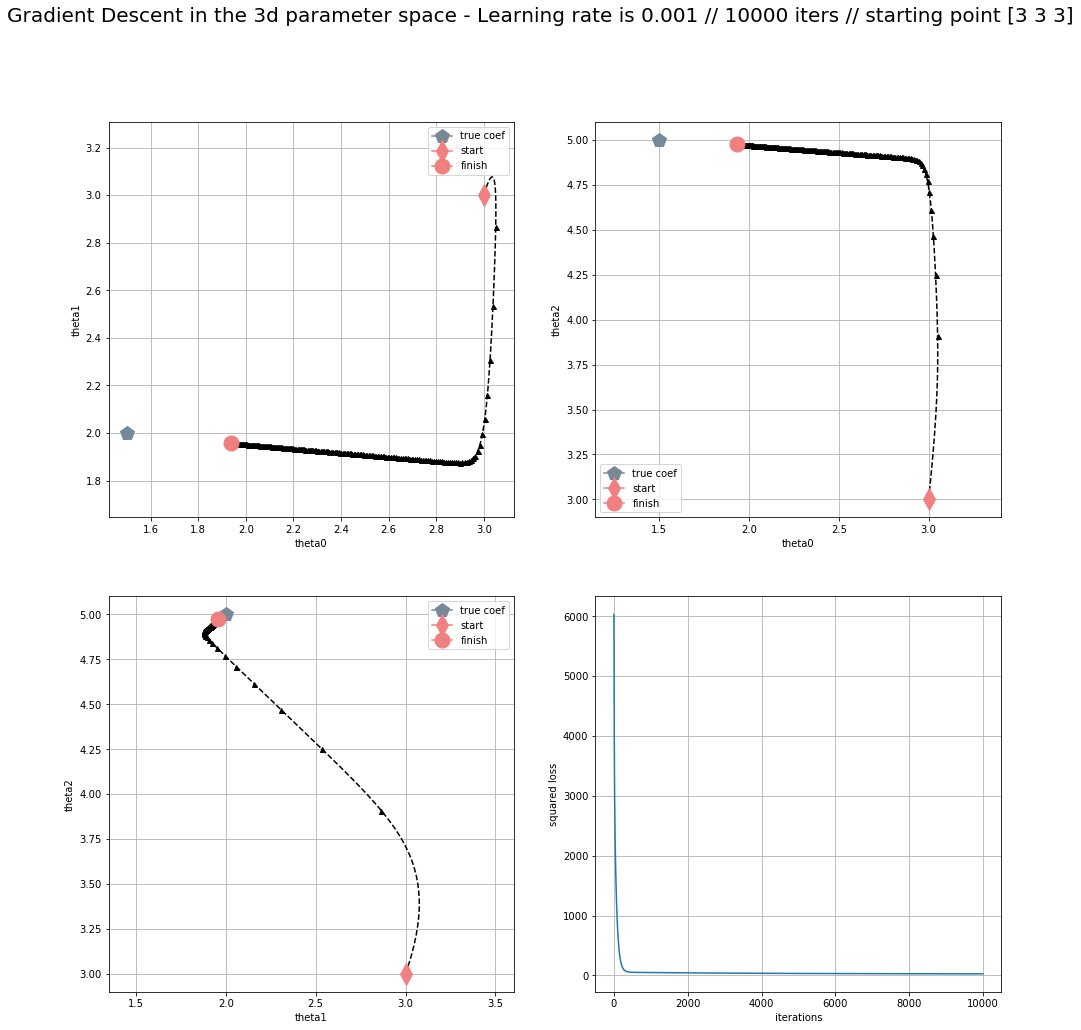

In [30]:
true_coef = [b, theta_1, theta_2]

def plot_ij(theta_path, i, j, ax):
    ax.plot(true_coef[i], true_coef[j],
            marker='p', markersize=15, label='true coef', 
            color='#778899')
    ax.plot(theta_path[:, i],theta_path[:, j],
            color='k', linestyle='--', marker='^', 
            markersize=5, markevery=50)
    ax.plot(theta_path[0, i], theta_path[0, j], marker='d', 
            markersize=15, label='start', color='#F08080')
    ax.plot(theta_path[-1, i], theta_path[-1, j], marker='o', 
            markersize=15, label='finish', color='#F08080')
    ax.set(
        xlabel='theta'+str(i),
        ylabel='theta'+str(j))
    ax.axis('equal')
    ax.grid(True)
    ax.legend(loc='best')
    

def plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial, gdtype='Gradient Descent'):
    fig = plt.figure(figsize=(16, 16))
    title = '{gdtype} in the 3d parameter space - Learning rate is {lr} // {iters} iters // starting point {initial}'
    title = title.format(gdtype=gdtype, lr=learning_rate, 
                         iters=num_iter, initial=theta_initial)
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(2, 2, 1)
    plot_ij(theta_path, 0, 1, ax)
    ax = fig.add_subplot(2, 2, 2)
    plot_ij(theta_path, 0, 2, ax)
    ax = fig.add_subplot(2, 2, 3)
    plot_ij(theta_path, 1, 2, ax)
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(loss_vec)
    ax.set(xlabel='iterations', ylabel='squared loss')
    ax.grid(True)
    

theta_path, loss_vec = gradient_descent(learning_rate, num_iter, theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial)



## Stochastic Gradient Descent
Rather than average the gradients across the whole dataset before taking a step, we will now take a step for every datapoint.  Each step will be somewhat of an "overreaction" but they should average out.  

## Exercise
The below code runs Stochastic Gradient descent, but runs through the data in the same order every time.  

1. Run the code and plot the graphs.  What do you notice?
2. Modify the code so that it randomly re-orders the data.  How do the sample trajectories compare?

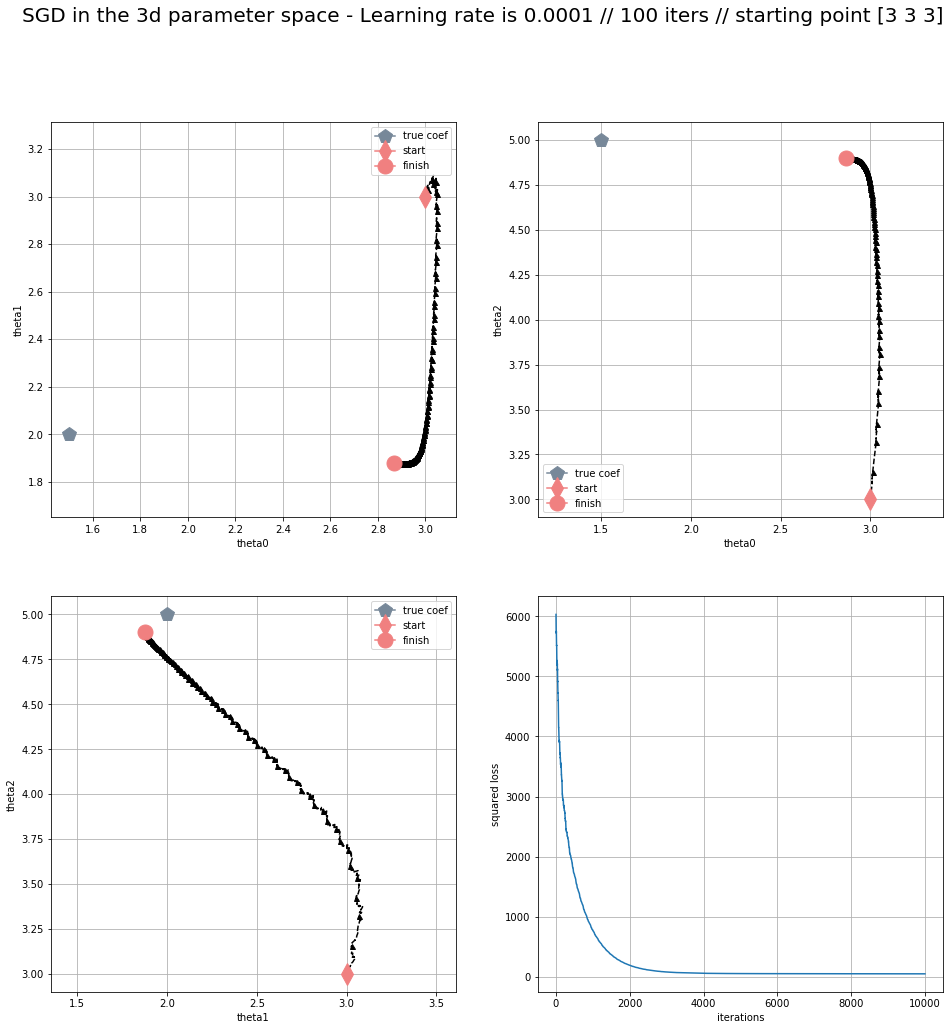

In [31]:
def stochastic_gradient_descent(learning_rate, num_iter, theta_initial):

    ## Initialization steps
    theta = theta_initial
    # below are different in STOCHASTIC gradient descent
    theta_path = np.zeros(((num_iter*num_obs)+1,3))
    theta_path[0,:] = theta_initial
    loss_vec = np.zeros(num_iter*num_obs)

    ## Main SGD loop
    count = 0
    for i in range(num_iter):
        for j in range(num_obs):
            count+=1
            y_pred = np.dot(theta.T,x_mat.T)
            loss_vec[count-1] = np.sum((y-y_pred)**2)
            grad_vec = (y[j]-y_pred[j])*(x_mat[j,:])
            theta = theta + learning_rate*grad_vec
            theta_path[count,:]=theta
    return theta_path, loss_vec

## Parameters to play with
learning_rate = 1e-4
num_iter = 100
theta_initial = np.array([3, 3, 3])


theta_path, loss_vec = stochastic_gradient_descent(learning_rate, 
                                                   num_iter, 
                                                   theta_initial)
plot_all(theta_path, loss_vec, learning_rate, 
         num_iter, theta_initial, 'SGD')

Play with the parameters below and observe the trajectory it results in

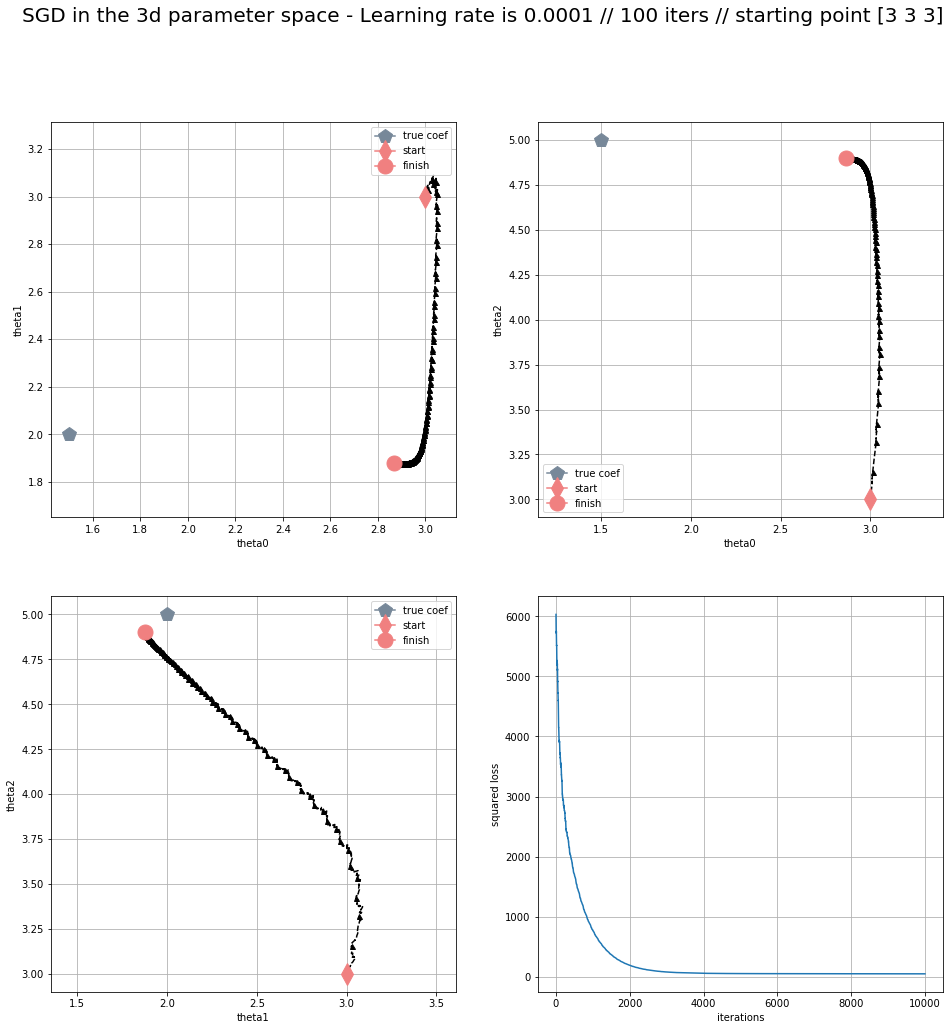

In [37]:
## Parameters to play with
learning_rate = 1e-4
num_iter = 100
theta_initial = np.array([3,3,3])

theta_path, loss_vec = stochastic_gradient_descent(learning_rate, 
                                                   num_iter, 
                                                   theta_initial)
plot_all(theta_path, loss_vec, learning_rate, num_iter, 
         theta_initial, 'SGD')

---
### Machine Learning Foundation (C) 2020 IBM Corporation